# Multinomial Naive Bayes for 20newsgroup data

The model here works with the 20newsgroups data from the ML repository from the following mentioned url:
https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz

The self implemented multinomial naive bayes model implemented here works on first 5000 frequent words, in order to reduce the size of sparse matrix in this implementation.

The model works with almost same frequency for the range of 2000-5000 frequent words. When we decrease the feature further for the learning of model, the accuracy decreases as we notice in the distribution of size VS accuracy. When we increase the number of features over 5000 words, the computational complexity of model increases, which sometimes crashes the kernel. 
The model for entire feature works with similar accuracy for our self-implemented multinomialNB model and with sklearn.multinomialNB.

But when all the features are include here, the sklearn.multinomialNB works perfectly fine, but our model gives warning that "the sparse matrix for the feature is ambiguous" and crashes the kernel.
Hence, we included the threshold to limit the feature and reduce the size of our sparse matrix.
For future work, other features of nltk library could be involved to reduce the features along with the nltk.stopwords. For eg:
nltk stemming and nltk lemmatisation.

The data exploration of 20newsgroups is displayed in Bernoulli Naive Bayes Model

In [1]:
#importing modules
import os
import codecs
import numpy as np
import string
import pandas as pd

# **Data Preprocessing**

In [2]:
#downloading and extracting the files on our server
import urllib.request
urllib.request.urlretrieve ("https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz", "a.tar.gz")
import tarfile
tar = tarfile.open("a.tar.gz")
tar.extractall()
tar.close()

In [3]:
#making a list of all the file paths and their corresponding class
f_paths=[]
i=-1
path="20_newsgroups"
folderlist=os.listdir(path)
if ".DS_Store" in folderlist:
  folderlist.remove('.DS_Store')
for folder in folderlist:
  i+=1
  filelist=os.listdir(path+'/'+folder)
  for file in filelist:
    f_paths.append((path+'/'+folder+'/'+file,i))
len(f_paths)

19997

In [4]:
#splitting the list of paths into training and testing data
from sklearn import model_selection
x_train,x_test=model_selection.train_test_split(f_paths)
len(x_train),len(x_test)

(14997, 5000)

In [5]:
#Making the lists X_train and X_test containg only the paths of the files in training and testing data
#First making lists Y_train and Y_test containing the classes of the training and testing data
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(len(x_train)):
  X_train.append(x_train[i][0])
  Y_train.append(x_train[i][1])
for i in range(len(x_test)):
  X_test.append(x_test[i][0])
  Y_test.append(x_test[i][1])
#Transforming Y_train and Y_test into 1 dimensional np arrays
Y_train=(np.array([Y_train])).reshape(-1)
Y_test=(np.array([Y_test])).reshape(-1)
#shape of Y_train and Y_test np arrays
Y_train.shape,Y_test.shape

((14997,), (5000,))

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#adding all the above lists and including punctuations to stop words
stop_words=list(stop)+list(set(string.punctuation))
len(stop_words)

211

In [8]:
#making vocabulary from the files in X_train i.e. training data
vocab={}
count =0
for filename in X_train:
  count+=1
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if len(word)>2:
      if word.lower() not in stop_words:
        if word.lower() in vocab:
          vocab[word.lower()]+=1
        else:
          vocab[word.lower()]=1
  f.close()

In [9]:
#length of the vocabulary
len(vocab)

355102

In [10]:
#sorting the vocabulary on the basis of the frequency of the word
#making the sorted vocabulary
import operator
sorted_vocab = sorted(vocab.items(), key= operator.itemgetter(1), reverse= True)   # sort the vocab based on frequency

In [11]:
#making the list feature_names containg the words with the frequency of the top 2000 words
feature_names = []
for i in range(len(sorted_vocab)):
    if(sorted_vocab[5000][1] <= sorted_vocab[i][1]):
        feature_names.append(sorted_vocab[i][0])

In [12]:
#length of the feature_names i.e. number of our features
print(len(feature_names))

5050


In [13]:
#making dataframes df_train and df_test with columns having the feature names i.e. the words
df_train=pd.DataFrame(columns=feature_names)
df_test=pd.DataFrame(columns=feature_names)

In [14]:
count_train,count_test=0,0

#transforming each file in X_train into a row in the dataframe df_train having columns as feature names and values as the frequency of that feature name i.e that word
for filename in X_train:
  count_train+=1
  #adding a row of zeros for each file
  df_train.loc[len(df_train)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  #parsing through all the words of the file
  for word in words:
    if word.lower() in df_train.columns:
      df_train[word.lower()][len(df_train)-1]+=1 #if the word is in the column names then adding 1 to the frequency of that word in the row
  f.close()
  
#transforming each file in X_test into a row in the dataframe df_test having columns as feature names and values as the frequency of that feature name i.e that word  
for filename in X_test:
  count_test+=1
  #adding a row of zeros for each file
  df_test.loc[len(df_test)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  #parsing through all the words of the file
  for word in words:
    if word.lower() in df_test.columns:
      df_test[word.lower()][len(df_test)-1]+=1 #if the word is in the column names then adding 1 to the frequency of that word in the row
  f.close()
  
#printing the number files tranformed in training and testing data
print(count_train,count_test)

14997 5000


In [15]:
#putting the values of the datafames into X_train and X_test
X_train=df_train.values
X_test=df_test.values

# **Self implemented Multinomial Naive Bayes**

In [16]:
#makes the nested dictionary required for NB using the training data
def fit(X,Y):
    dictionary={}
    y_classes=set(Y)
    #iterating over each class of y
    for y_class in y_classes:
        #adding the class as a key to the dictionary
        dictionary[y_class]={}
        n_features=X.shape[1]
        rows=(Y==y_class)
        #making the arrays having only those rows where class is y_class
        X_y_class=X[rows]
        Y_y_class=Y[rows]
        #adding the total number of files as total_data
        dictionary["total_data"]=X.shape[0]
        #iterating over each feature
        for i in range(n_features):
            #adding the feature as a key which has the count of that word in Y=y_class as its value
            dictionary[y_class][i]=X_y_class[:,i].sum()
            #adding the total number of files as total_class
            dictionary[y_class]["total_class"]=X_y_class.shape[0]
            #adding the sum of all the words in Y=y_class i.e. total no. of words in Y=y_class
            dictionary[y_class]["total_words"]=X_y_class.sum()
    return dictionary

In [17]:
#calculates the probability of the feature vector belonging to a particular class and the probability of the class
#returns the product of the above 2 probabilities
def probability(x,dictionary,y_class):
    #output intially has probability of the particular class in log terms
    output=np.log(dictionary[y_class]["total_class"])-np.log(dictionary["total_data"])
    n_features=len(dictionary[y_class].keys())-2
    #calculates probability of x being in a particular class by calulating probability of each word being in that class
    for i in range(n_features):
        if x[i]>0:
            #probability of the ith word being in this class in terms of log
            p_i=x[i]*(np.log(dictionary[y_class][i] + 1) - np.log(dictionary[y_class]["total_words"]+n_features))
            output+=p_i
    return output

In [18]:
#predicts the class to which a single file feature vector belongs to
def predictSinglePoint(x,dictionary):
    classes=dictionary.keys()
    #contains the class having the max probability
    best_class=1
    #max probability
    best_prob=-1000
    first=True
    #iterating over all the classes
    for y_class in classes:
        if y_class=="total_data":
            continue
        #finding probability of this file feature vector belonging to y_class
        p_class=probability(x,dictionary,y_class)
        if(first or p_class>best_prob):
            best_prob=p_class
            best_class=y_class
        first=False
    return best_class

In [19]:
#predicts the classes to which all the file feature vectors belong in the testing data
def predict(X_test,dictionary):
    y_pred=[]
    #iterates over all the file feature vectors
    for x in X_test:
        #predicts the class of a particular file feature vector
        x_class=predictSinglePoint(x,dictionary)
        y_pred.append(x_class)
    return y_pred

In [20]:
Y_train.shape

(14997,)

In [23]:
threshList = [0.1,0.3,0.5,0.7,0.9,1.0]
acc = []
for i in threshList:
    print("Learning with ",str(i*100),"% of training data")
    threshold_train = int(i*X_train.shape[0])
    X_train_slice = X_train[:threshold_train,:]
    Y_train_slice = Y_train[:threshold_train,]
    dictionary=fit(X_train_slice,Y_train_slice) #makes the required dictionary for all the sliced sets, i.e., learns on different sizes of training set
    y_pred=predict(X_test,dictionary)# predicts the classes
    #check how many predcitions actually match original test labels
    test_acc=np.sum(y_pred==Y_test)/float(Y_test.shape[0])
    print("Accuracy for ",str(i*100),"% sliced training set is: ",str(test_acc))
    acc.append(test_acc)

Learning with  10.0 % of training data
Accuracy for  10.0 % sliced training set is:  0.781
Learning with  30.0 % of training data
Accuracy for  30.0 % sliced training set is:  0.823
Learning with  50.0 % of training data
Accuracy for  50.0 % sliced training set is:  0.8428
Learning with  70.0 % of training data
Accuracy for  70.0 % sliced training set is:  0.8506
Learning with  90.0 % of training data
Accuracy for  90.0 % sliced training set is:  0.862
Learning with  100.0 % of training data
Accuracy for  100.0 % sliced training set is:  0.8618


# **Conclusions**

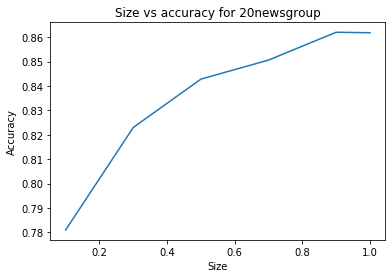

In [27]:
import matplotlib.pyplot as plt

acc = np.array(acc)
thresh_size = np.array(threshList)
plt.plot(thresh_size,acc)
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Size vs accuracy for 20newsgroup")
#plt.grid()
plt.show()

In [43]:
cnf_matrix = confusion_matrix(Y_test,y_pred)
cnf_matrix

array([[193,   0,   0,   0,   0,   0,   0,   0,   5,   2,   1,   1,   2,
          2,   0,   2,   2,   2,   3,  36],
       [  0, 200,  12,   4,   3,   9,  12,   6,   3,   1,   0,   0,   7,
          3,   1,   0,   0,   0,   0,   0],
       [  1,  12, 208,  10,   4,   8,   9,   1,   1,   0,   0,   1,   6,
          0,   2,   0,   1,   0,   0,   3],
       [  0,   2,   9, 216,   7,   4,  18,   2,   2,   0,   0,   0,   4,
          1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   5,   7, 213,   1,   9,   1,   1,   0,   0,   0,   2,
          0,   4,   0,   0,   0,   0,   0],
       [  0,  12,   6,   3,   1, 208,   4,   1,   2,   0,   0,   1,   4,
          1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   3,   3,   1,   0, 244,   5,   3,   1,   2,   1,   6,
          0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   8, 240,   4,   0,   0,   0,   3,
          0,   1,   0,   1,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1,   7,   4, 228,   0,   0,  

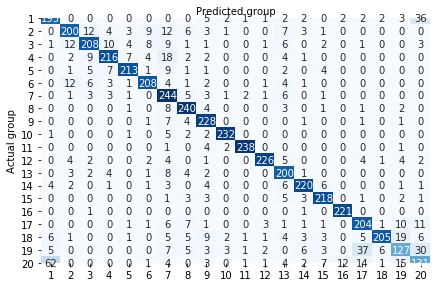

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual group')
plt.xlabel('Predicted group');

In [28]:
print(classification_report(Y_test,y_pred)) #classification report for testing data

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       245
           1       0.82      0.81      0.81       246
           2       0.88      0.88      0.88       253
           3       0.81      0.88      0.85       244
           4       0.86      0.90      0.88       241
           5       0.94      0.85      0.89       290
           6       0.76      0.90      0.82       241
           7       0.88      0.93      0.91       242
           8       0.89      0.96      0.93       239
           9       0.97      0.96      0.96       261
          10       0.99      0.96      0.98       270
          11       0.96      0.91      0.93       238
          12       0.81      0.84      0.82       248
          13       0.97      0.89      0.93       237
          14       0.93      0.93      0.93       248
          15       0.95      0.98      0.97       258
          16       0.78      0.88      0.83       265
          17       0.94    